In [1]:
!pip3 install pmdarima

     |████████████████████████████████| 1.4 MB 533 kB/s            


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import numpy as np

# CONSTS
KAGGLE_PATH = '/kaggle/input/bmstutechnoparkhw3rnn/'
LOCAL_PATH = './mgtu2022rnn/'
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

%matplotlib inline

cpu is available.


# Ноутбук для ДЗ №4 обработка временных последовательностей RNN
В данном дз вам будут данных времменая последовательно, которая описывает распределение хитов по времени за несколько лет. Вам нужно будет обучить модель RNN на исторических данных и потом сделать предсказание для "будущего" года, в текущей задаче это 2019 год

## Готовим данные
Три файла с данными
1. исторические данные - train
2. Тестовые данные текущего момента - derived
3. Пример сабмита резкльтатов конкурса на кагле

In [3]:
def read_set(file):
    data = pd.read_csv(file)
    data['date'] = pd.to_datetime(data['date'])
    data = data.rename(columns = {'DATE':'date'})
    data = data.rename(columns = {'hits':'value'})
    data = data.set_index('date')
    return data

In [4]:
data_train = read_set(KAGGLE_PATH + 'train.csv')
data_test =  read_set(KAGGLE_PATH + 'derived.csv')
data_sample = read_set(KAGGLE_PATH + 'sample_submission.csv')

### Проверим наши данные, что мы загрузили

In [5]:
print( data_train.info() )
print( data_test.info() )
print( data_sample.info() )

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2016-01-01 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   1096 non-null   int64
dtypes: int64(1)
memory usage: 17.1 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None


## Графики наших временных последовательностей

In [6]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_datasets(df_s, names, title=None):
    data = []
    for i, df in enumerate(df_s):
        value = go.Scatter(
            x=df.index,
            y=df.value,
            mode="lines",
            name=names[i],
            marker=dict(),
            text=df.index,
        )

        data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [7]:
plot_datasets([data_train, data_test, data_sample], names=['Train', 'Test', 'Sample'], title='Data')

## Статистическая модель [ARIMA](https://ru.wikipedia.org/wiki/ARIMA)


In [8]:
# обучаем модель
# arima_model=model = pm.auto_arima(data_train, 
#                                    seasonal=True, m=4, test='adf', error_action='ignore',  
#                                    suppress_warnings=True,
#                                    stepwise=True, trace=True
#                               )

In [9]:
# prediction = pd.DataFrame(model.predict(n_periods=int(data_test.size)), data_test.index)

In [10]:
# prediction = prediction.rename(columns = {0:'value'})

смотрим, что она нам предсказала

In [11]:
# plot_datasets([data_train, data_test, prediction], names=['Train', 'Test', 'Arima'], title='Data')

### Функция подсчета метрик для конкурса

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def MAPE(y_true, y_pred):
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-6)
    mape = np.average(mape) * 100
    return mape

def calculate_metrics(value, prediction):
    result_metrics = {'mae' : mean_absolute_error(value, prediction),
                      'rmse' : mean_squared_error(value, prediction, squared=False),
                      'r2' : r2_score(value, prediction),
                      'mape': MAPE(value, prediction)
                     }
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    print("MAPE Score:                ", result_metrics["mape"])
    return result_metrics

### MAPE для ARIMA и тестового сабмишена

In [13]:
res = calculate_metrics(data_test, data_sample)

Mean Absolute Error:        114824304.19726028
Root Mean Squared Error:    133297170.7602661
R^2 Score:                  -2.855154469968816
MAPE Score:                 44.81735178659308


## Из пандас строим датасет

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [15]:
class TSDataset(Dataset):
    def __init__(self, data, seq_len):
        super().__init__()
        # будем обучать окнами, поэтому сделаем отступ
        self._len = len(data) - (seq_len - 1)
        self._len -= 1 # Добавим 1 к seq_len, чтобы возвращать y
        print(data, self._len)
        self.data = data
        self.seq_len = seq_len
        
    def __len__(self):
        return self._len
    
    def __getitem__(self, idx):
        d = self.data[idx:idx + self.seq_len]
        targets = []
        days   = []
        months = []
        year = []
        y = []
        for i, row in enumerate(d.iterrows()):
            if i+1 < self.seq_len:
                targets += [ row[1]['value'] ]
                days += [ row[0].day ]
                months += [ row[0].month ]
                year += [ row[0].year ]
            else:
                y += [ row[1]['value'] ]
            
        return torch.LongTensor(days), \
                torch.LongTensor(months), \
                torch.LongTensor(year), \
                torch.FloatTensor(targets), \
                torch.FloatTensor(y)

In [16]:
data_train

,value
date,
2016-01-01,201979088
2016-01-02,223095158
2016-01-03,233791442
2016-01-04,259684220
2016-01-05,267112490
...,...
2018-12-27,241134980
2018-12-28,234865040
2018-12-29,195884690


In [17]:
data_test

,value
date,
2019-01-01,108624560
2019-01-02,130814504
2019-01-03,147999398
2019-01-04,148669766
2019-01-05,131564540
...,...
2019-12-27,248681252
2019-12-28,139485986
2019-12-29,122282606


In [18]:
data_train_scaled = data_train.copy()
data_test_scaled = data_test.copy()

shift_size = 20

data_test_shifted = pd.concat([ data_train_scaled.tail(shift_size), data_test_scaled])
data_shifted = data_train_scaled.iloc[:-shift_size]

# Нормализуем таргеты
scaler = get_scaler('minmax')

data_shifted[['value']] = scaler.fit_transform(data_shifted[['value']])
data_test_shifted[['value']] = scaler.transform(data_test_shifted[['value']])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
ds_train = TSDataset(data_shifted, shift_size) 
ds_test  = TSDataset(data_test_shifted, shift_size)

               value
date                
2016-01-01  0.241202
2016-01-02  0.304510
2016-01-03  0.336578
2016-01-04  0.414207
2016-01-05  0.436478
...              ...
2018-12-07  0.403303
2018-12-08  0.081568
2018-12-09  0.089404
2018-12-10  0.482527
2018-12-11  0.470566

[1076 rows x 1 columns] 1056
               value
date                
2018-12-12  0.443092
2018-12-13  0.428252
2018-12-14  0.374028
2018-12-15  0.066189
2018-12-16  0.073814
...              ...
2019-12-27  0.381219
2019-12-28  0.053842
2019-12-29  0.002265
2019-12-30  0.312135
2019-12-31  0.026970

[385 rows x 1 columns] 365


In [20]:
print(ds_train[1057])
ds_test[0]

(tensor([23, 24, 25, 26, 27, 28, 29, 30,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11]), tensor([11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12]), tensor([2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
        2018, 2018, 2018, 2018, 2018, 2018, 2018]), tensor([0.3587, 0.0416, 0.0671, 0.4814, 0.4447, 0.4468, 0.4452, 0.4057, 0.0866,
        0.0956, 0.4487, 0.4751, 0.4497, 0.4463, 0.4033, 0.0816, 0.0894, 0.4825,
        0.4706]), tensor([]))


(tensor([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
         30]),
 tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12]),
 tensor([2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
         2018, 2018, 2018, 2018, 2018, 2018, 2018]),
 tensor([0.4431, 0.4283, 0.3740, 0.0662, 0.0738, 0.4172, 0.4029, 0.4355, 0.4169,
         0.3572, 0.0669, 0.0673, 0.4111, 0.3801, 0.3786, 0.3586, 0.3398, 0.2229,
         0.0122]),
 tensor([-0.0335]))

## Теперь нужно определить нашу модель 

In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, use_ctx=False):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.use_ctx = use_ctx

        self.day_emb = nn.Embedding(32, input_dim[0])
        self.month_emb = nn.Embedding(13, input_dim[1])

        self.lstm = nn.LSTM(
            sum(input_dim)+1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bias=True
        )

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, batch, ctx=None):
        # Initializing hidden state for first input with zeros
        days, months, _, x, y = batch

        days_tensor = self.day_emb(days)
        months_tensor = self.day_emb(months)

        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        if ctx == None or self.use_ctx == False:
            ctx = (h0, c0)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model

        input = torch.cat([days_tensor, months_tensor, x.unsqueeze(-1)], dim=-1)
        out, ctx = self.lstm(input, (ctx[0].detach(), ctx[1].detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out, ctx

### Определяем класс, в котором будем обучать

In [22]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        
        self.ctx_last = None
        
    def train_step(self, batch, ctx=None):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat, ctx = self.model(batch, ctx)

        y = batch[-1]
        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item(), ctx

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50):
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        
        ctx = None
        for epoch in tqdm(range(1, n_epochs + 1)):
            batch_losses = []
            for batch in train_loader:
                loss, ctx = self.train_step(batch, ctx)
                self.ctx_last = ctx
                batch_losses.append(loss)
                
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)
            
            with torch.no_grad():
                batch_val_losses = []
                ctx_val = None
                for batch_eval in val_loader:
                    self.model.eval()
                    yhat, ctx_val = self.model(batch_eval, ctx_val)
                    val_loss = self.loss_fn(batch_eval[-1], yhat).item()
                    batch_val_losses.append(val_loss)
                    
                validation_loss = np.mean(batch_val_losses)
                self.scheduler.step(validation_loss)
                self.val_losses.append(validation_loss)

            if epoch % 10 == 0:
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1):
        with torch.no_grad():
            predictions = []
            values = []
            ctx = None
            for batch in tqdm(test_loader):
                self.model.eval()
                yhat, ctx = self.model(batch, ctx)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(batch[-1].to(device).detach().numpy())

        return predictions, values
    
    def make_prediction(self, test_loader, batch_size=1):
        with torch.no_grad():
            self.model.eval()
            predictions = []
            values = []

            _, _, _, x_test, _ = next(iter(test_loader))
            ctx = (torch.unsqueeze(self.ctx_last[0][:, -1, :], 1), torch.unsqueeze(self.ctx_last[1][:, -1, :], 1))
            for batch in tqdm(test_loader):
                made_batch = [batch[0], batch[1], batch[2], x_test, batch[4]]

                y_test = batch[-1]
                yhat, ctx = self.model(made_batch, ctx)
                
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())
                
                torch.reshape(x_test, (-1,))
                x_test = torch.cat((torch.reshape(x_test, (-1,)), torch.reshape(yhat, (-1,))))[None, 1:]
                

        return predictions, values
            

    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Test loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

### Определяем даталоадеры для теста и трейна

In [23]:
def get_loss_func(loss_name):
    losses = {
        'mse': nn.MSELoss(reduction="mean"),
        'l1': nn.L1Loss()
    }
    return losses[loss_name.lower()]

In [24]:
batch_size = 16
dl_train = DataLoader(ds_train, batch_size, shuffle=False, drop_last=True)
dl_test = DataLoader(ds_test, batch_size, shuffle=False, drop_last=True)
dl_test_one = DataLoader(ds_test, 1, shuffle=False)

In [25]:
# input_dim = len(X_train.columns)
input_dim = (4, 4)
output_dim = 1
hidden_dim = 64
layer_dim = 2
dropout = 0.2
n_epochs = 500
learning_rate = 1e-3
weight_decay = 1e-5

model_params = {'input_dim': input_dim,
                'hidden_dim': hidden_dim,
                'layer_dim': layer_dim,
                'output_dim': output_dim,
                'dropout_prob': dropout,
                'use_ctx': True
               }

model = LSTMModel(**model_params)

loss_fn = get_loss_func('l1')
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.1, min_lr=1e-8, verbose=True)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [26]:
opt.train(dl_train, dl_test, batch_size=batch_size, n_epochs=n_epochs)

  0%|          | 0/500 [00:00<?, ?it/s]

[10/500] Training loss: 0.1833	 Validation loss: 0.1696
[20/500] Training loss: 0.1765	 Validation loss: 0.1587
[30/500] Training loss: 0.1141	 Validation loss: 0.0646
[40/500] Training loss: 0.0745	 Validation loss: 0.0645
[50/500] Training loss: 0.0529	 Validation loss: 0.0582
[60/500] Training loss: 0.0497	 Validation loss: 0.0622
[70/500] Training loss: 0.0475	 Validation loss: 0.0621
[80/500] Training loss: 0.0435	 Validation loss: 0.0508
[90/500] Training loss: 0.0399	 Validation loss: 0.0529
[100/500] Training loss: 0.0380	 Validation loss: 0.0482
[110/500] Training loss: 0.0331	 Validation loss: 0.0498
[120/500] Training loss: 0.0308	 Validation loss: 0.0546
[130/500] Training loss: 0.0352	 Validation loss: 0.0558
[140/500] Training loss: 0.0324	 Validation loss: 0.0484
[150/500] Training loss: 0.0392	 Validation loss: 0.0651
[160/500] Training loss: 0.0335	 Validation loss: 0.0490
[170/500] Training loss: 0.0332	 Validation loss: 0.0535
[180/500] Training loss: 0.0304	 Validat

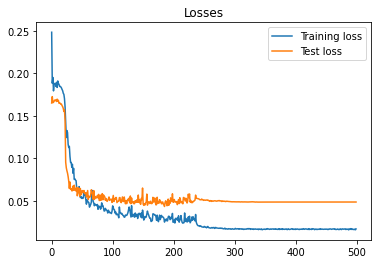

In [27]:
opt.plot_losses()

In [28]:
# Predictions for evaluating model
predictions, values = opt.evaluate(
    dl_test_one,
    batch_size=1
)

  0%|          | 0/365 [00:00<?, ?it/s]

In [29]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.tail(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, data_test, scaler)
df_result

,value,prediction
date,,
2019-01-01,110355568.0,138822512.0
2019-01-02,108624568.0,148503952.0
2019-01-03,130814504.0,137078672.0
2019-01-04,147999392.0,164898976.0
2019-01-05,148669760.0,169074976.0
...,...,...
2019-12-27,258102608.0,247686096.0
2019-12-28,248681248.0,231868304.0
2019-12-29,139485984.0,150936272.0


In [30]:
result_metrics = calculate_metrics(df_result.value, df_result.prediction)

Mean Absolute Error:        17265616.0
Root Mean Squared Error:    26849770.0
R^2 Score:                  0.8439753331228687
MAPE Score:                 9.798995405435562


In [31]:
eval_answer = pd.DataFrame(df_result['prediction']).rename(columns={'prediction': 'value'})
plot_datasets([data_train, data_test, eval_answer], names=['Train', 'Test', 'Eval'], title='Data')

In [32]:
# Predictions for real testing model
predictions, values = opt.make_prediction(
    dl_test_one,
    batch_size=1
)

df_prediction = format_predictions(predictions, values, data_test, scaler)
df_prediction

  0%|          | 0/365 [00:00<?, ?it/s]

,value,prediction
date,,
2019-01-01,110355568.0,124005680.0
2019-01-02,108624568.0,151302432.0
2019-01-03,130814504.0,149555344.0
2019-01-04,147999392.0,174448432.0
2019-01-05,148669760.0,178729056.0
...,...,...
2019-12-27,258102608.0,252783712.0
2019-12-28,248681248.0,239719760.0
2019-12-29,139485984.0,216175552.0


In [33]:
result_metrics = calculate_metrics(df_prediction.value, df_prediction.prediction)

Mean Absolute Error:        51525436.0
Root Mean Squared Error:    71326504.0
R^2 Score:                  -0.1010674302675727
MAPE Score:                 28.212663531303406


In [34]:
answer = pd.DataFrame(df_prediction['prediction']).rename(columns={'prediction': 'value'})
plot_datasets([data_train, data_test, answer], names=['Train', 'Test', 'Preds'], title='Data')

In [35]:
answer.rename(columns={'value': 'hits'}).to_csv('answer.csv')